In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings('ignore')

In [2]:
folder_path = r'C:\Users\Rafael_Fagundes\Downloads\delve_compiled_data.csv'

df = pd.read_csv(folder_path)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904965 entries, 0 to 1904964
Data columns (total 41 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   Unnamed: 0                            int64  
 1   Audience Type                         object 
 2   Tactic                                object 
 3   Media Buy Name                        object 
 4   Campaign Name                         object 
 5   Fiscal Quarter                        object 
 6   Fiscal Week Year                      object 
 7   Country                               object 
 8   Display Funnel Mapped                 object 
 9   Display Dell Vehicle Mapped           object 
 10  Display Business Unit Mapped          object 
 11  Display Site Name Mapped              object 
 12  Audience Type Name                    object 
 13  Impressions                           float64
 14  Clicks                                float64
 15  Spend          

In [4]:
# Filter the dataset by US, 2024Q3 and 3P
df_filtered = df[(df['Fiscal Quarter'] == '2024-Q3')
       & (df['Country'] == 'United States')
       & (df['Audience Type'] == '3PD')]

In [5]:
# Create a flag for the main Vendors
df_filtered['Permutive_flag'] = df_filtered['Media Buy Name'].str.contains(r'Permutive|Permutvie|permu|Permu|ermu', case=False)

df_filtered['TTD_flag'] = df_filtered['Media Buy Name'].str.contains(r'The Trade Desk', case=False) | (df_filtered['Audience Source'].str.contains(r'The Trade Desk', case=False))

df_filtered['LR_flag'] = df_filtered['Media Buy Name'].str.contains(r'Liveramp', case=False) | (df_filtered['Audience Source'].str.contains(r'Liveramp', case=False))

df_filtered['NS_flag'] = df_filtered['Media Buy Name'].str.contains(r'Neustar', case=False) | (df_filtered['Audience Source'].str.contains(r'Neustar', case=False))

df_filtered['DV360_flag'] = df_filtered['Media Buy Name'].str.contains(r'dv360', case=False) | (df_filtered['Audience Source'].str.contains(r'dv360', case=False))

In [6]:
# Create a column with all provider names
df_filtered['Provider'] = np.where(df_filtered['Permutive_flag'], 'Permutive', 
                                   np.where(df_filtered['TTD_flag'], 'TTD', 
                                           np.where(df_filtered['LR_flag'], 'LiveRamp', 
                                                   np.where(df_filtered['NS_flag'], 'Neustar', 
                                                           np.where(df_filtered['DV360_flag'], 'DV360', None)))))


In [11]:
# Group KPIs by Provider
grouped_df = df_filtered.groupby([
    'Fiscal Week Year',
    'Provider'
]).agg({
    'Impressions': 'sum',
    'Clicks': 'sum',
    'Spend': 'sum',
    'Net Rev': 'sum',
    'HVE': 'sum'
}).reset_index()

In [23]:
# Create additional KPIs
grouped_df['CTR'] = grouped_df['Clicks'] / grouped_df['Impressions']
grouped_df['CPM'] = 1000 * grouped_df['Spend'] / grouped_df['Impressions']
grouped_df['CPC'] = grouped_df['Spend'] / grouped_df['Clicks']

grouped_df.head()

,Fiscal Week Year,Provider,Impressions,Clicks,Spend,Net Rev,HVE,CTR,CPM,CPC
0,2024-W27,DV360,61522765.0,74428.0,228805.001782,1841370.25,63434.0,0.001210,3.719030,3.074179
1,2024-W27,LiveRamp,139647.0,18.0,312.528856,58303.05,3207.0,0.000129,2.237992,17.362714
2,2024-W27,Neustar,1.0,0.0,0.000000,1379.00,0.0,0.000000,0.000000,NaN
3,2024-W27,Permutive,246063.0,308.0,1794.384678,0.00,0.0,0.001252,7.292379,5.825924
4,2024-W27,TTD,6816174.0,3613.0,118468.202516,1117.96,0.0,0.000530,17.380455,32.789428


<Axes: xlabel='Provider', ylabel='CTR'>

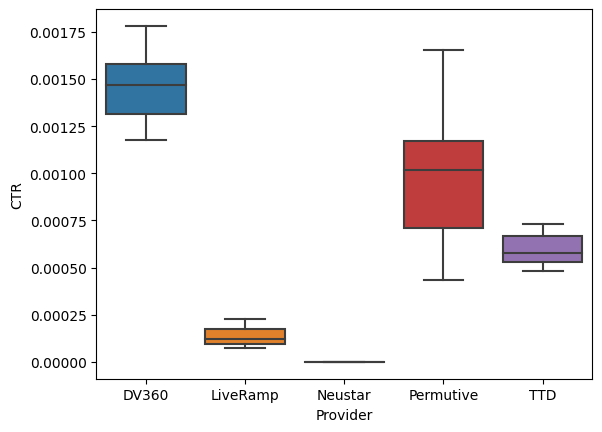

In [25]:
sns.boxplot(data=grouped_df, x='Provider',y='CTR')